# Chapter 2: Background

The reconstruction task is to invert this relationship and find the activity distribution $\hat{f}$ from the acquired data that best approximates the true distribution $f$. However, due to the strong presence of noise, this problem is ill-posed and difficult to solve.


In [ ]:
import odl
import numpy as np
import matplotlib.pyplot as plt

from utils.plots import plot_slice

## Sinogram

One way of visualising acquired data is to create a sinogram. This is achieved by calculating the line integral along all the parallel LORs for a fixed angle θ (projection) and then repeating the process for each angle θ. The plot each corresponding projection as a function of the displacement parameter t on a (t, θ) plane, a sinogram is generated.


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Set image dimensions
IMG_WIDTH: int = 147
IMG_HEIGHT: int = 147

In [ ]:
# Create a 2D uniform grid
uniform_space: odl.DiscretizedSpace = odl.uniform_discr(
    min_pt=(-20.0, -20.0),
    max_pt=(20.0, 20.0),
    shape=(IMG_WIDTH, IMG_HEIGHT),
    dtype="float64",
)

# Create a 2D Cube phantom
cube_phantom: np.ndarray = np.flip(
    np.array(odl.phantom.geometric.indicate_proj_axis(space=uniform_space))
)

# Normalize the phantom between [0, 1]
cube_phantom = np.clip(cube_phantom, 0, 1)

In [ ]:
# Angles: uniformly spaced, n = 1000, min = 0, max = pi
angle_partition = odl.uniform_partition(0, np.pi, 1000)

# Detector: uniformly sampled, n = 500, min = -30, max = 30
detector_partition = odl.uniform_partition(-30, 30, 500)

# Make a parallel beam geometry with flat detector for each angle
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)

# Calculate the Radon transform of the object
ray_trafo = odl.tomo.RayTransform(uniform_space, geometry, impl="skimage")

# Do the forward projection and get the sinogram
cube_sinogram = np.array(ray_trafo(cube_phantom))

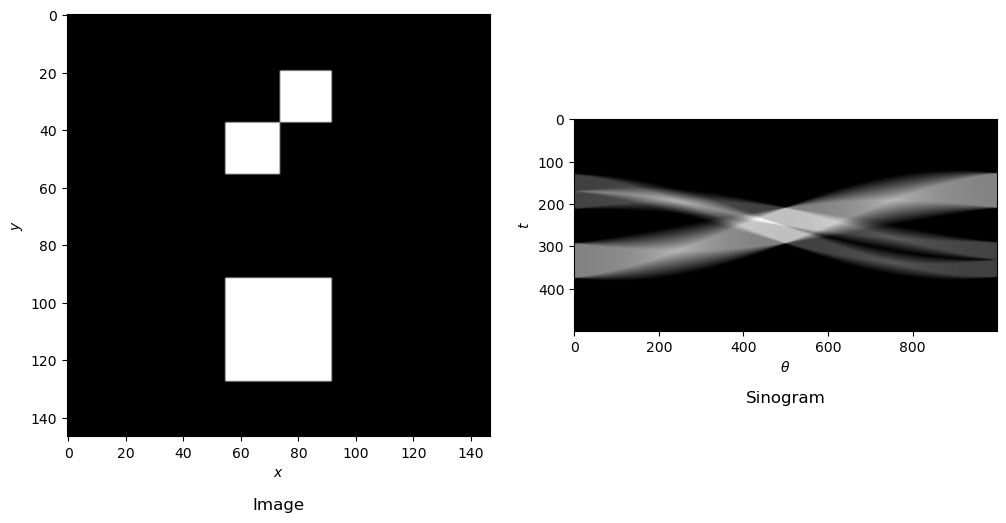

In [5]:
# Plot the phantom and sinogram
plt.figure(figsize=(12, 6))

# Plot the phantom
plt.subplot(121)
plt.imshow(cube_phantom, cmap="grey")
plt.title("Image", y=-0.01, pad=-50)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.axis("on")

# Plot the sinogram
plt.subplot(122)
plt.imshow(cube_sinogram.T, cmap="grey")
plt.title("Sinogram", y=-0.01, pad=-50)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$t$")
plt.axis("on")

plt.show()

## Back Projection

The PET projections are mathematically described by the Radon transform, which is often referred to as the forward operator.

$
    Rf(t, \theta)=\int _{l_{t, \theta}}f(x,y) dl
$

Applying the inverse Radon transform to the projected data (sinogram), namely the backward projection, produces a blurred version of the original image as displayed in Figure 2.5. This happens because the backward projection doesn’t know the exact locations of the activities and sets a constant value in all pixels along the LOR, causing a linear overlap of the back projections and the consequent visual blurring of the image.


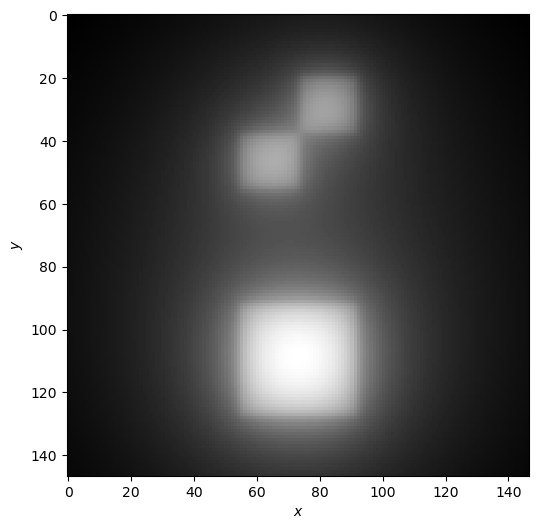

In [ ]:
# Back projection
cube_recon = ray_trafo.adjoint(cube_sinogram)

# Plot the reconstructed image
plot_slice(cube_recon)

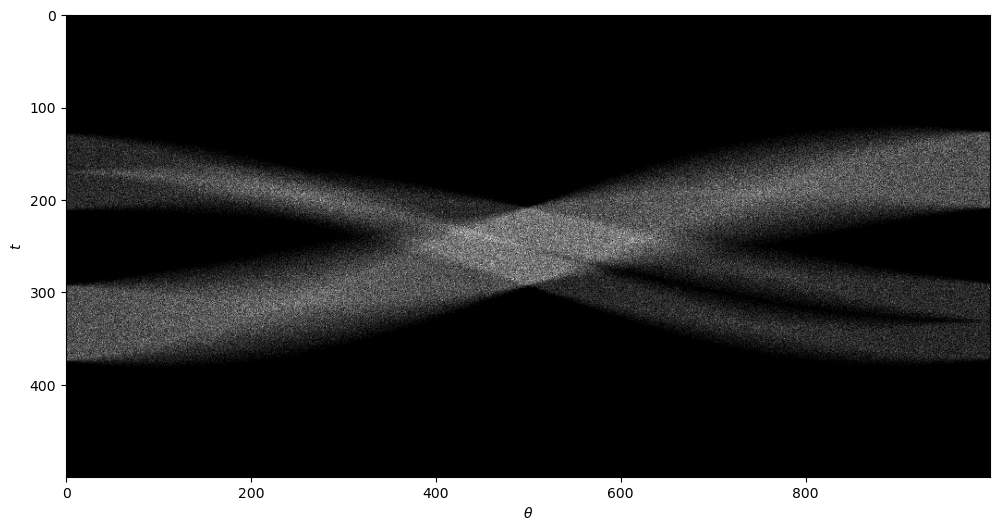

In [7]:
# Add noise to the sinogram
noisy_sinogram = np.random.poisson(cube_sinogram)

# Plot the noisy sinogram
plot_slice(noisy_sinogram.T, dual=True)

## Filtered Back Projection

Analytical reconstruction algorithms attempt to mathematically solve the inversion problem, assuming ideal conditions and neglecting the presence of noise in PET data. For these reasons, while these methods are fast and analytically tractable, they often produce low-quality reconstructions that are still affected by noise, requiring further denoising.

The most popular analytical algorithm is Filtered Back Projection (FBP), which attempts to solve the blurring shown above by filtering the projections in the Fourier domain before applying the back projection.

$
    f(x, y)=\frac{1}{2} {B}\left\{{F}^{-1}[|\omega| {F}({R} f)(\omega, \theta)]\right\}(x, y)
$

where $F$ and $F^{−1}$ are respectively the Fourier transform and its inverse, ω is the
2D Fourier filter and B is the inverse of the Radon transform (backward projector). There are various types of filters, each offering a different balance between
image sharpness and noise reduction


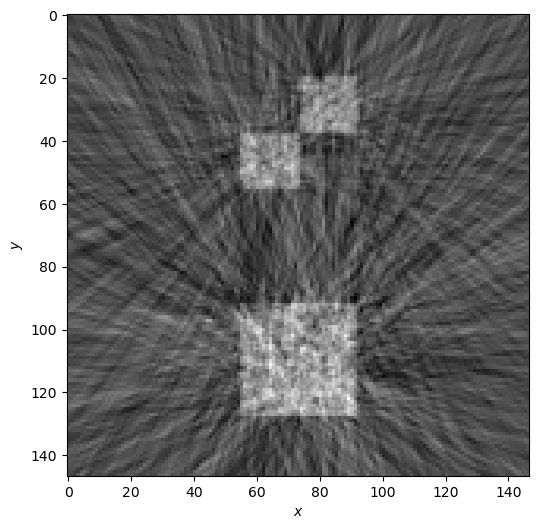

In [8]:
# Create a filtered back projection operator
fbp = odl.tomo.analytic.filtered_back_projection.fbp_op(ray_trafo, padding=True)

# Reconstruct the image using FBP
fbp_cube_recon = fbp(noisy_sinogram)

# Plot the reconstructed image
plot_slice(fbp_cube_recon)

## MLEM

Iterative methods try to solve the problem by modelling it statistically. This approach has the benefit of improving reconstruction accuracy, as it aligns better with the inherently statistical nature of the emission process. However, it also introduces complexity, which renders the analytical treatment of these algorithms unfeasible. This is the reason why the solution has to be found iteratively. The most widely used iterative algorithm is the Maximum Likelihood Expectation Maximisation (MLEM) algorithm, in which Maximum Likelihood (ML) is the cost function used to calculate the similarity between the measured data $g$ and the current estimate $f_k$ and Expectation Maximisation (EM) is the algorithm used to correct the current estimate.

$
f_{(k+1)}=\frac{f_k}{A^{*} \mathbb{I}} A^{*}\left(\frac{g}{A f_k}\right)
$

where $f_k$ is the current estimate, $f_{(k+1)}$ is the updated estimate, $\mathbb{I}$ is a all-ones matrix, $A$ represents the forward projection operator and $A^{*}$ its adjoint (or back projection). At each iteration, the measured data $g$ is divided by the forward projection of the current estimate $f_k$. This ratio is then back projected and divided by a weighting factor, defined as $A^{*} \mathbb{I}$, to obtain a correction term that is used to update the current estimate.


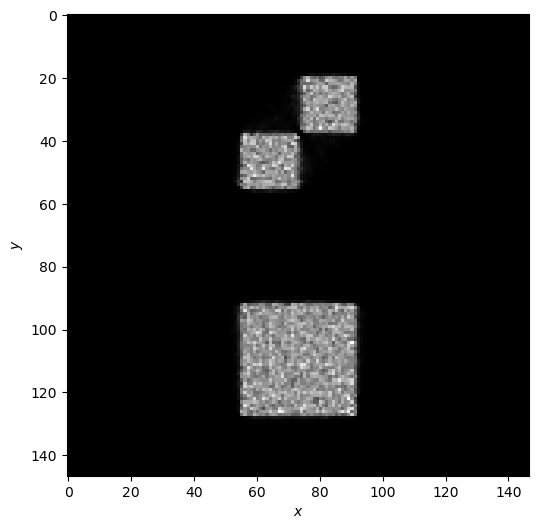

In [9]:
# Create an MLEM reconstruction object (Initialised with ones)
mlem_cube_recon = ray_trafo.domain.element(np.ones_like(cube_phantom))

# Reconstruct the image using MLEM
odl.solvers.iterative.statistical.mlem(
    ray_trafo, mlem_cube_recon, noisy_sinogram, niter=50
)

# Plot the reconstructed image
plot_slice(mlem_cube_recon)